In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 26))
train_y = Variable(torch.sign(torch.cos(train_x.data * (8 * math.pi))))

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class GPClassificationModel(gpytorch.GPModel):
    def __init__(self):
        super(GPClassificationModel,self).__init__(BernoulliLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-6, 6))
        self.grid_covar_module = GridInterpolationKernel(self.covar_module)
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-6,6))
        self.initialize_interpolation_grid(30, grid_bounds=[(0, 1)])
    
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.grid_covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

model = GPClassificationModel()
model.condition(train_x, train_y)

GPClassificationModel (
  (likelihood): BernoulliLikelihood (
  )
  (mean_module): ConstantMean (
  )
  (covar_module): RBFKernel (
  )
  (grid_covar_module): GridInterpolationKernel (
    (base_kernel_module): RBFKernel (
    )
  )
)

In [5]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 100))
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        if plot_train_data:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
        ax.plot(test_x.data.numpy(), pred_labels.data.numpy(), 'b')
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

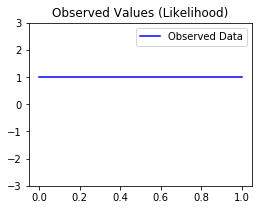

In [6]:
f = plot_model_and_predictions(model, plot_train_data=False)

In [7]:
# Find optimal model hyperparameters
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(200):
    optimizer.zero_grad()
    output = model.forward(train_x)
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/200 - Loss: %.3f   log_lengthscale: %.3f' % (
        i + 1, loss.data[0],
        model.covar_module.log_lengthscale.data.squeeze()[0],
    ))
    optimizer.step()
    
# Set back to eval mode
model.eval()
None

/mnt/c/Users/Gardn/gpytorch/gpytorch/kernels/rbf_kernel.py:42: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  grad.mul_(grad_output.transpose(0, 1))


Iter 1/20 - Loss: 124387.266   log_lengthscale: 0.000
Iter 2/20 - Loss: 95226.211   log_lengthscale: -0.100
Iter 3/20 - Loss: 62905.898   log_lengthscale: -0.197
Iter 4/20 - Loss: 46264.176   log_lengthscale: -0.291
Iter 5/20 - Loss: 47089.543   log_lengthscale: -0.387
Iter 6/20 - Loss: 33840.344   log_lengthscale: -0.484
Iter 7/20 - Loss: 27962.873   log_lengthscale: -0.583
Iter 8/20 - Loss: 17726.693   log_lengthscale: -0.682
Iter 9/20 - Loss: 13262.880   log_lengthscale: -0.780
Iter 10/20 - Loss: 9455.298   log_lengthscale: -0.879
Iter 11/20 - Loss: 7450.604   log_lengthscale: -0.980
Iter 12/20 - Loss: 9800.687   log_lengthscale: -1.082
Iter 13/20 - Loss: 12090.223   log_lengthscale: -1.183
Iter 14/20 - Loss: 8691.625   log_lengthscale: -1.284
Iter 15/20 - Loss: 9430.754   log_lengthscale: -1.382
Iter 16/20 - Loss: 4785.322   log_lengthscale: -1.477
Iter 17/20 - Loss: 7581.789   log_lengthscale: -1.571
Iter 18/20 - Loss: 2816.344   log_lengthscale: -1.664
Iter 19/20 - Loss: 2702.914

Iter 157/20 - Loss: 40.443   log_lengthscale: -3.779
Iter 158/20 - Loss: 47.092   log_lengthscale: -3.781
Iter 159/20 - Loss: 38.757   log_lengthscale: -3.783
Iter 160/20 - Loss: 49.226   log_lengthscale: -3.785
Iter 161/20 - Loss: 59.204   log_lengthscale: -3.788
Iter 162/20 - Loss: 49.664   log_lengthscale: -3.790
Iter 163/20 - Loss: 30.976   log_lengthscale: -3.792
Iter 164/20 - Loss: 56.154   log_lengthscale: -3.794
Iter 165/20 - Loss: 51.598   log_lengthscale: -3.796
Iter 166/20 - Loss: 38.605   log_lengthscale: -3.798
Iter 167/20 - Loss: 32.936   log_lengthscale: -3.800
Iter 168/20 - Loss: 51.743   log_lengthscale: -3.801
Iter 169/20 - Loss: 49.159   log_lengthscale: -3.803
Iter 170/20 - Loss: 52.447   log_lengthscale: -3.805
Iter 171/20 - Loss: 56.344   log_lengthscale: -3.807
Iter 172/20 - Loss: 54.020   log_lengthscale: -3.809
Iter 173/20 - Loss: 42.789   log_lengthscale: -3.812
Iter 174/20 - Loss: 62.547   log_lengthscale: -3.814
Iter 175/20 - Loss: 49.386   log_lengthscale: 

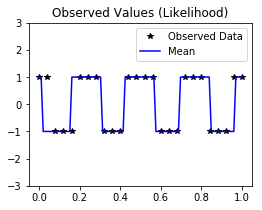

In [8]:
f = plot_model_and_predictions(model)